In [1]:
from pysb.core import *
from pysb.integrate import *
import matplotlib.pyplot as plt
import numpy as np
from pysb.integrate import ScipyOdeSimulator as SOS
%matplotlib inline

In [2]:
Model ()


Monomer('L', ['r'])
Monomer('R', ['l', 'ysc'])
Monomer('YSC', ['lr'])
Monomer('ICD', ['csl', 'l'], {'l':['cyto', 'nuc']})
Monomer('CSL', ['icd', 'gh'])# gh--> binding site for geneHes1
Monomer('gHes1', ['ic', 'ph', 'f'], {'f':['on','off']}) 
# ic --> binding site for ICD:CSL compex, 
# ph--> binding site for inhibitor protein HES1
Monomer('mHes1', ['f','l'], {'f':['on', 'off'],'l':['cyto','nuc']})
Monomer('pHES1', ['gh']) # gh--> binding site for geneHes1
Monomer('ASCL1')
Monomer('SLUG')
Monomer('NGN2', ['h', 'f'], {'f':['on', 'off']})

Monomer('NGN2', ['h', 'f'], {'f': ['on', 'off']})

In [3]:
#Defining Observables
Observable('ICD_obs', ICD(csl = None,l='nuc'))
Observable('CSL_on', ICD(csl = 1,l='nuc')%CSL(icd = 1))
Observable('Lig', L(r=None))
Observable('Receptor', R(l=None))
Observable('LR_on', R(l=1)%L(r=1))
Observable('CSL_off', CSL(icd=None, gh=None))
Observable('mRNA_Hes1', mHes1(f='on',l='cyto'))
Observable('protein_HES1', pHES1(gh=None))
Observable('Slug_levels', SLUG)
Observable('Ascl1_levels', ASCL1)

Observable('Ascl1_levels', ASCL1())

In [4]:
#Defining initial conditions and parameters
Parameter('L_0', 10000)
Parameter('R_0', 5000)
Parameter('YSC_0', 500)
Parameter('CSL_0', 1000)
Parameter('ASCL1_0', 200)
Parameter('NGN2_0', 200)
Parameter('gHes1_0', 400)

Initial(L(r = None), L_0)
Initial(R(l = None, ysc = None), R_0)
Initial(YSC(lr = None), YSC_0)
Initial(CSL(icd = None, gh = None), CSL_0)
Initial(gHes1(ic=None, ph=None, f='off'), gHes1_0)

In [5]:
# L + R <> L:R
# YSC + L:R <> YSC:L:R
# YSC:L:R >> YSC + ICDc
Parameter('kLRf', 1e-5)
Parameter('kLRr', 1e-5)
Parameter('kLRYSCf', 1e-3)
Parameter('kLRYSCr', 1e-5)
Parameter('kYSCICD', 1e-2)
Rule('LR_binding', L(r = None) + R(l= None, ysc = None) <> L(r = 1)%R(l=1, ysc = None), kLRf,kLRr)
Rule('YSC_LR_binding', YSC(lr = None) + L(r = 1)%R(l=1, ysc = None) <> YSC(lr = 2)%L(r = 1)%R(l =1, ysc = 2), kLRYSCf, kLRYSCr)
Rule('ICD_formation', YSC(lr = 2)%L(r = 1)%R(l =1, ysc = 2) >> YSC(lr = None) + ICD(csl = None,l='cyto'), kYSCICD)

Rule('ICD_formation', YSC(lr=2) % L(r=1) % R(l=1, ysc=2) >> YSC(lr=None) + ICD(csl=None, l='cyto'), kYSCICD)

In [6]:
# ICDc <> ICDn
# ICDn + CSL <> ICDn:CSL
Parameter('kICD_c_n', 1)
Parameter('kICD_n_c', 1e-3)
Parameter('kICDCSLf', 1e-3)
Parameter('kICDCSLr', 1e-3)
Rule('ICD_cyto_to_nucleus', ICD(csl=None,l='cyto') <> ICD(csl=None,l='nuc'), kICD_c_n,kICD_c_n)
Rule('ICD_CSL_complex', ICD(csl = None,l='nuc') + CSL(icd = None) <> ICD(csl = 1,l='nuc')%CSL(icd = 1), kICDCSLf, kICDCSLr)

Rule('ICD_CSL_complex', ICD(csl=None, l='nuc') + CSL(icd=None) <> ICD(csl=1, l='nuc') % CSL(icd=1), kICDCSLf, kICDCSLr)

In [7]:
# gHES1(off) + ICDn:CSL <> gHES1(off):ICDn:CSL
# gHES1(off):ICDn:CSL <> gHES1(on):ICDn:CSL
# gHES1(on):ICDn:CSL >> mHES1n(off) + gHES1(off):ICDn:CSL
# mHES1n(off) <> mHES1c(off)
# mHES1c(on) >> pHES1 + mHES1c(off)
Parameter('kgICf', 1e-4)
Parameter('kgICr', 1e-4)
Parameter('kDNApolbind', 1e-2)
Parameter('kDNApolunbind', 1e-2)
Parameter('kg_trcxn', 1e-2)
Parameter('kmH_n_c', 1e-1)
Parameter('kmH_c_n', 1e-4)
Parameter('kRNApolbind', 1e-2)
Parameter('kRNApolunbind', 1e-2)
Parameter('km_trlxn', 1e-1)
Rule('gHes1_binds_ICDCSL', gHes1(ic=None, ph=None, f='off') + ICD(csl=1,l='nuc')%CSL(icd=1, gh=None) <> gHes1(ic=2,ph=None, f='off')%ICD(csl=1,l='nuc')%CSL(icd=1,gh=2), kgICf, kgICr)
Rule('DNAPol_binds_active_gHcomplex', gHes1(ic=2,ph=None, f='off')%ICD(csl=1,l='nuc')%CSL(icd=1,gh=2) <> gHes1(ic=2,ph=None, f='on')%ICD(csl=1,l='nuc')%CSL(icd=1,gh=2), kDNApolbind, kDNApolunbind)
Rule('gHes1_IC_complex_to_mRNA_Hes1', gHes1(ic=2,ph=None, f='on')%ICD(csl=1,l='nuc')%CSL(icd=1,gh=2) >> mHes1(f='off',l='nuc') + gHes1(ic=2,ph=None, f='off')%ICD(csl=1,l='nuc')%CSL(icd=1,gh=2), kg_trcxn)
Rule('mRNA_Hes1_nuc_to_cyto', mHes1(f='off',l='nuc') <> mHes1(f='off',l='cyto'), kmH_n_c, kmH_c_n)
Rule('mHes1_binds_RNAPol', mHes1(f='off', l='cyto') <> mHes1(f='on', l='cyto'), kRNApolbind, kRNApolunbind)
Rule('mRNA_Hes1_to_Protein_HES1', mHes1(f='on',l='cyto') >> pHES1(gh=None) + mHes1(f='off',l='cyto'), km_trlxn)

Rule('mRNA_Hes1_to_Protein_HES1', mHes1(f='on', l='cyto') >> pHES1(gh=None) + mHes1(f='off', l='cyto'), km_trlxn)

In [8]:
# mHES1c(off) <> mHES1c(on)
# gHES1(off) + pHES1 <> gHES1(off):pHes1
# gHES1(on):ICDn:CSL + pHES1 <> gHES1(off):ICDn:CSL:pHES1
# gHES1(off):pHES1 + ICDn:CSL <> gHES1(off):pHES1:ICDn:CSL

Parameter('kgpHf', 1e-4)
Parameter('kgpHr', 1e-4)
Parameter('kgICpHf', 1e-5)
Parameter('kgICpHr', 1e-5)
Parameter('kgpHICf', 1e-5)
Parameter('kgpHICr', 1e-5)
Rule('pHES1_inhibits_gHes1_1', gHes1(ic=None,ph=None,f='off')+pHES1(gh=None) <> gHes1(ic=None,ph=3,f='off')%pHES1(gh=3), kgpHf, kgpHr)
Rule('pHES1_inhibits_gHes1_2', gHes1(ic=2,ph=None, f='on')%ICD(csl=1,l='nuc')%CSL(icd=1,gh=2) + pHES1(gh=None) <> gHes1(ic=2,ph=3, f='off')%ICD(csl=1,l='nuc')%CSL(icd=1,gh=2)%pHES1(gh=3), kgICpHf, kgICpHr)
Rule('pHES1_inhibits_gHes1_3', gHes1(ic=None,ph=3,f='off')%pHES1(gh=3) + ICD(csl=1,l='nuc')%CSL(icd=1, gh=None) <> gHes1(ic=2,ph=3,f='off')%pHES1(gh=3)%ICD(csl=1,l='nuc')%CSL(icd=1, gh=2), kgpHICf, kgpHICr)


Expression('slug_synth_exp', CSL_on)
Rule('slug_synth', None >> SLUG(), slug_synth_exp)

Rule('slug_synth', None >> SLUG(), slug_synth_exp)

In [9]:
# Decay of species
Parameter('d_L', 1e-3)
Parameter('d_R', 1e-3)
Parameter('d_YSC', 1e-7)
Parameter('d_ICD', 1e-2)
Parameter('d_CSL', 1e-7)
Parameter('d_mH', 1)
Parameter('d_pH', 1e-1)
Parameter('d_Slug', 1e-8)
Parameter('d_NGN2', 1e-12)
Parameter('d_Ascl1', 1e-8)
Parameter('r_R', 1)
Parameter('r_L', 5)
Rule('Ligand_decay', L(r=None) >> None, d_L)
Rule('Receptor_decay', R(l=None,ysc=None) >> None, d_R)
Rule('YSC_decay', YSC(lr=None) >> None, d_YSC)
Rule('ICD_decay', ICD(csl=None,l='cyto') >> None, d_ICD)
Rule('CSL_decay', CSL(icd=None, gh=None) >> None, d_CSL)
Rule('mRNA_Hes1_decay', mHes1(f='off',l='cyto') >> None, d_mH)
Rule('protein_HES1_decay', pHES1(gh=None) >> None, d_pH)
Rule('Slug_decay', SLUG() >> None, d_Slug)
Rule('Ascl1_decay', ASCL1() >> None, d_Ascl1)
Rule('Ngn2_decay', NGN2(h=None, f='off') >> None, d_NGN2)
Rule('Recycle_ligand', None >> L(r=None), r_L)
Rule('Recycle_Receptor', None >> R(l=None,ysc=None), r_R)

Rule('Recycle_Receptor', None >> R(l=None, ysc=None), r_R)

In [10]:
tspan = np.linspace(0, 10000, 1001)
sim1 = SOS(model, tspan)
sim_result = sim1.run()

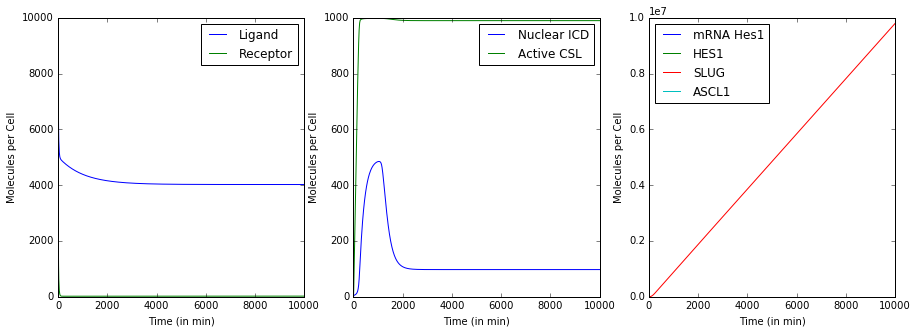

In [11]:
plt.figure(figsize = (15,5))
plt.subplot(131)
plt.plot(tspan, sim_result.observables['Lig'], label = 'Ligand')
plt.plot(tspan, sim_result.observables['Receptor'], label = 'Receptor')
plt.xlabel("Time (in min)", fontsize=10)
plt.ylabel("Molecules per Cell", fontsize=10)
plt.legend(loc = 0)

plt.subplot(132)
plt.plot(tspan, sim_result.observables['ICD_obs'], label = 'Nuclear ICD')
plt.plot(tspan, sim_result.observables['CSL_on'], label = 'Active CSL')
plt.xlabel("Time (in min)", fontsize=10)
plt.ylabel("Molecules per Cell", fontsize=10)
plt.legend(loc = 0)

plt.subplot(133)
plt.plot(tspan, sim_result.observables['mRNA_Hes1'], label = 'mRNA Hes1')
plt.plot(tspan, sim_result.observables['protein_HES1'], label = 'HES1')
plt.plot(tspan, sim_result.observables['Slug_levels'], label = 'SLUG')
plt.plot(tspan, sim_result.observables['Ascl1_levels'], label = 'ASCL1')
plt.xlabel("Time (in min)", fontsize=10)
plt.ylabel("Molecules per Cell", fontsize=10)
plt.legend(loc = 0)
plt.show()